In [1]:
import sys
import os
import numpy as np
import pandas as pd

import h5py

import matplotlib.pyplot as plt

from scipy.stats import spearmanr, pearsonr

from scipy.ndimage import gaussian_filter1d

import seaborn as sns

import matplotlib.cm as cm
import matplotlib.colors as colors

import matplotlib as mpl
from matplotlib.text import TextPath
from matplotlib.patches import PathPatch, Rectangle
from matplotlib.font_manager import FontProperties
from matplotlib import gridspec
from matplotlib.ticker import FormatStrFormatter

#Helper function to draw a letter at a given position
def dna_letter_at(letter, x, y, yscale=1, ax=None, color=None, alpha=1.0):

    #Define letter heights and colors
    fp = FontProperties(family="DejaVu Sans", weight="bold")
    globscale = 1.35
    LETTERS = {	"T" : TextPath((-0.305, 0), "T", size=1, prop=fp),
                "G" : TextPath((-0.384, 0), "G", size=1, prop=fp),
                "A" : TextPath((-0.35, 0), "A", size=1, prop=fp),
                "C" : TextPath((-0.366, 0), "C", size=1, prop=fp),
                "UP" : TextPath((-0.488, 0), '$\\Uparrow$', size=1, prop=fp),
                "DN" : TextPath((-0.488, 0), '$\\Downarrow$', size=1, prop=fp),
                "(" : TextPath((-0.25, 0), "(", size=1, prop=fp),
                "." : TextPath((-0.125, 0), "-", size=1, prop=fp),
                ")" : TextPath((-0.1, 0), ")", size=1, prop=fp)}
    COLOR_SCHEME = {'G': 'orange',#'orange', 
                    'A': 'green',#'red', 
                    'C': 'blue',#'blue', 
                    'T': 'red',#'darkgreen',
                    'UP': 'green', 
                    'DN': 'red',
                    '(': 'black',
                    '.': 'black', 
                    ')': 'black'}


    text = LETTERS[letter]

    #Choose color
    chosen_color = COLOR_SCHEME[letter]
    if color is not None :
        chosen_color = color

    #Draw letter onto axis
    t = mpl.transforms.Affine2D().scale(1*globscale, yscale*globscale) + \
        mpl.transforms.Affine2D().translate(x,y) + ax.transData
    p = PathPatch(text, lw=0, fc=chosen_color, alpha=alpha, transform=t)
    if ax != None:
        ax.add_artist(p)
    
    return p

#Function to plot sequence logo
def plot_seq_scores(importance_scores, figsize=(16, 2), plot_y_ticks=True, y_min=None, y_max=None, save_figs=False, fig_name="default") :

    importance_scores = importance_scores.T

    fig = plt.figure(figsize=figsize)
    
    ref_seq = ""
    
    #Loop over reference sequence letters
    for j in range(importance_scores.shape[1]) :
        argmax_nt = np.argmax(np.abs(importance_scores[:, j]))
        
        if argmax_nt == 0 :
            ref_seq += "A"
        elif argmax_nt == 1 :
            ref_seq += "C"
        elif argmax_nt == 2 :
            ref_seq += "G"
        elif argmax_nt == 3 :
            ref_seq += "T"

    ax = plt.gca()
    
    #Loop over reference sequence letters and draw
    for i in range(0, len(ref_seq)) :
        mutability_score = np.sum(importance_scores[:, i])
        color = None
        dna_letter_at(ref_seq[i], i + 0.5, 0, mutability_score, ax, color=color)
    
    plt.sca(ax)
    plt.xticks([], [])
    plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    
    plt.xlim((0, len(ref_seq)))
    
    #plt.axis('off')
    
    if plot_y_ticks :
        plt.yticks(fontsize=12)
    else :
        plt.yticks([], [])
    
    #Set axis limits
    if y_min is not None and y_max is not None :
        plt.ylim(y_min, y_max)
    elif y_min is not None :
        plt.ylim(y_min)
    else :
        plt.ylim(
            np.min(importance_scores) - 0.1 * np.max(np.abs(importance_scores)),
            np.max(importance_scores) + 0.1 * np.max(np.abs(importance_scores))
        )
    
    plt.axhline(y=0., color='black', linestyle='-', linewidth=1)

    #for axis in fig.axes :
    #    axis.get_xaxis().set_visible(False)
    #    axis.get_yaxis().set_visible(False)

    plt.tight_layout()

    if save_figs :
        plt.savefig(fig_name + ".png", transparent=True, dpi=300)
        plt.savefig(fig_name + ".eps")

    plt.show()


In [2]:
#Load gene dataframe and select tissue

tissue = 'liver'

gene_df = pd.read_csv("/home/jlinder/seqnn/data/diff_expr/gtex_diff_expr_log2fc_5k.csv", sep='\t')
gene_df = gene_df.query("tissue == '" + str(tissue) + "'").copy().reset_index(drop=True)
gene_df = gene_df.drop(columns=['Unnamed: 0'])

#Select CFHR2 example gene
gene_df = gene_df.query("gene_base == 'ENSG00000080910'").copy().reset_index(drop=True)

print("len(gene_df) = " + str(len(gene_df)))

#Get list of gene for tissue
tissue_genes = gene_df['gene_base'].values.tolist()

print("len(tissue_genes) = " + str(len(tissue_genes)))


len(gene_df) = 1
len(tissue_genes) = 1


In [3]:
#Load scores for the selected set of GTEx tissues (grad)

import gc

seqs = None
strands = None
chrs = None
starts = None
ends = None
genes = None

all_scores_hyp = []
all_scores = []

gtex_tissues = ['liver']

#Load score file
score_file = h5py.File('../../../borzoi/examples/saved_models/gtex_CFHR2/scores_f3c0.h5', 'r')

#Get scores and onehots
scores = score_file['grads'][()][..., 0]
seqs = score_file['seqs'][()]

#Get auxiliary information
strands = score_file['strand'][()]
strands = np.array([strands[j].decode() for j in range(strands.shape[0])])

chrs = score_file['chr'][()]
chrs = np.array([chrs[j].decode() for j in range(chrs.shape[0])])

starts = np.array(score_file['start'][()])
ends = np.array(score_file['end'][()])

genes = score_file['gene'][()]
genes = np.array([genes[j].decode().split(".")[0] for j in range(genes.shape[0])])

gene_dict = {gene : gene_i for gene_i, gene in enumerate(genes.tolist())}

#Get index of rows to keep
keep_index = []
for tissue_gene in tissue_genes :
    keep_index.append(gene_dict[tissue_gene])

#Filter/sub-select data
scores = scores[keep_index, ...]
seqs = seqs[keep_index, ...]
strands = strands[keep_index]
chrs = chrs[keep_index]
starts = starts[keep_index]
ends = ends[keep_index]
genes = genes[keep_index]

#Append hypothetical scores
all_scores_hyp.append(scores[None, ...])

#Append input-gated scores
all_scores.append((scores * seqs)[None, ...])

#Collect garbage
gc.collect()

#Collect final scores
scores_hyp = np.concatenate(all_scores_hyp, axis=0)
scores = np.concatenate(all_scores, axis=0)

print("scores_hyp.shape = " + str(scores_hyp.shape))
print("scores.shape = " + str(scores.shape))

score_file = None

#Collect garbage
gc.collect()


scores_hyp.shape = (1, 1, 524288, 4)
scores.shape = (1, 1, 524288, 4)


0

-- Example = 0 --
 - ENSG00000080910(+)
 - chr1:196692638-197216926
 -- min_val = -1.719
 -- max_val = 3.385
 - (Gradient score profiles per tissue) - 


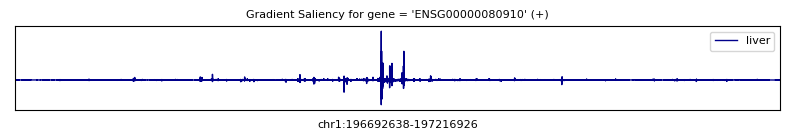

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 251085
 - max_pos (abs) = 196943723
 - chr1:196943627-196943819
 - y_min = -1.78648438
 - y_max = 3.45445312
liver


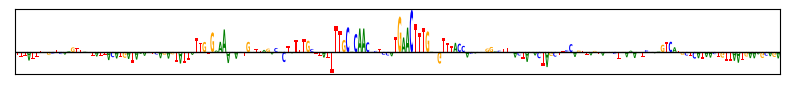

--------------------



In [4]:
#Enumerate and visualize attributions; liver example CFHR2

save_index = []

#Visualization parameters
logo_width = 192

top_n = 1

use_gaussian = True
min_padding = 65536
gaussian_sigma = 8
local_window = 1024

main_tissue_ix = 0

tissue_colors = ['darkblue']

#Loop over examples
for example_ix in range(top_n) :
    
    print("-- Example = " + str(example_ix)+ " --")
    
    print(" - " + tissue_genes[example_ix] + "(" + str(strands[example_ix]) + ")")
    print(" - " + chrs[example_ix] + ":" + str(starts[example_ix]) + "-" + str(ends[example_ix]))

    #Grad analysis
    
    #Calculate min and max scores globally (for scales)
    min_val = np.min(scores[:, example_ix, ...])
    max_val = np.max(scores[:, example_ix, ...])
    
    print(" -- min_val = " + str(round(min_val, 4)))
    print(" -- max_val = " + str(round(max_val, 4)))
    
    max_abs_val = max(np.abs(min_val), np.abs(max_val))

    min_val -= 0.1 * max_abs_val
    max_val += 0.1 * max_abs_val

    print(" - (Gradient score profiles per tissue) - ")
    
    #Gradient profiles across input sequence
    f, ax = plt.subplots(len(gtex_tissues), 1, figsize=(8, len(gtex_tissues) * 1.5))
    
    if len(gtex_tissues) == 1 :
        ax = [ax]

    #Loop over tissues
    for tissue_ix in range(len(gtex_tissues)) :

        #Get tissue scores
        score = scores[tissue_ix, example_ix, ...]

        l1 = ax[tissue_ix].plot(np.arange(seqs.shape[1]), np.sum(score, axis=-1), linewidth=1, linestyle='-', color=tissue_colors[tissue_ix], label=gtex_tissues[tissue_ix])
        
        plt.sca(ax[tissue_ix])
        
        plt.xlim(0, seqs.shape[1])
        plt.ylim(min_val, max_val)
        
        plt.legend(handles=[l1[0]], fontsize=8)
        
        plt.yticks([], [])
        plt.xticks([], [])
    
    plt.sca(ax[0])
    plt.title("Gradient Saliency for gene = '" + tissue_genes[example_ix] + "' (" + str(strands[example_ix]) + ")", fontsize=8)
    
    plt.sca(ax[len(gtex_tissues)-1])
    plt.xlabel(chrs[example_ix] + ":" + str(starts[example_ix]) + "-" + str(ends[example_ix]), fontsize=8)
    
    plt.sca(plt.gca())
    plt.tight_layout()
    
    plt.show()

    #Apply gaussian filter
    smooth_score = np.sum(scores[main_tissue_ix, example_ix, ...], axis=-1)
    if use_gaussian :
        smooth_score = gaussian_filter1d(smooth_score.astype('float32'), sigma=gaussian_sigma, truncate=2).astype('float16')
    
    #Calculate min/max positions and (differential) values
    max_pos = np.argmax(smooth_score[min_padding:-min_padding]) + min_padding

    print(" - (Attribution at position of Max positive differential saliency) -")

    print(" - max_pos (rel) = " + str(max_pos))
    print(" - max_pos (abs) = " + str(starts[example_ix] + max_pos))
    
    #Visualize contribution scores
    plot_start = max_pos - logo_width // 2
    plot_end = max_pos + logo_width // 2
    
    print(" - " + chrs[example_ix] + ":" + str(starts[example_ix] + max_pos - logo_width // 2) + "-" + str(starts[example_ix] + max_pos + logo_width // 2))

    #Logo min/max value across tissues
    min_logo_val = np.min(scores[:, example_ix, plot_start:plot_end, :])
    max_logo_val = np.max(scores[:, example_ix, plot_start:plot_end, :])

    max_abs_logo_val = max(np.abs(min_logo_val), np.abs(max_logo_val))

    min_logo_val -= 0.02 * max_abs_logo_val
    max_logo_val += 0.02 * max_abs_logo_val

    print(" - y_min = " + str(round(min_logo_val, 8)))
    print(" - y_max = " + str(round(max_logo_val, 8)))

    #Loop over tissues
    for tissue_ix in range(len(gtex_tissues)) :
        print(gtex_tissues[tissue_ix])

        #Get tissue-specific scores
        score = scores[tissue_ix, example_ix, plot_start:plot_end, :]

        #Plot scores as sequence logo
        plot_seq_scores(
            score,
            y_min=min_logo_val,
            y_max=max_logo_val,
            figsize=(8, 1),
            plot_y_ticks=False,
        )
    
    print("--------------------")
    print("")
